In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.parametervector import ParameterVector
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import Statevector,state_fidelity
from scipy.special import rel_entr
from qiskit.quantum_info import SparsePauliOp

# **QUANTUM SINGLE-TASK LEARNING**

# **Data Preparation — Binary Quantization of Stock Returns**

In [2]:
# Data loading and preprocessing
def load_and_preprocess_stock_data(file_path, T):
    df = pd.read_csv(file_path)
    close_prices = df['Close'].values
    returns = (np.diff(close_prices) > 0).astype(int)
    X, y = [], []
    for i in range(len(returns) - T):
        context = returns[i:i+T]
        target = returns[i+T]
        X.append(context)
        y.append(target)
    return np.array(X), np.array(y), returns

# **Context Preparation**

In [3]:
def get_context_prob_distribution(X_train, T):
    counts = Counter(tuple(x) for x in X_train)
    total = sum(counts.values())
    dist = np.zeros(2 ** T)
    for context, freq in counts.items():
        idx = int("".join(map(str, context)), 2)
        dist[idx] = freq / total
    return dist

In [4]:
def build_context_loader_circuit(prob_dist, T):
    prob_dist = np.asarray(prob_dist)
    prob_dist = prob_dist / np.sum(prob_dist)  # Normalize if needed
    amplitudes = np.sqrt(prob_dist)            # Amplitude encoding
    sv = Statevector(amplitudes)               # Create statevector
    qc = QuantumCircuit(T)
    qc.initialize(sv.data, qc.qubits)          # Load into quantum circuit
    return qc

# **PQC Construction**

In [5]:
def build_pqc_template(num_qubits, num_layers):
    num_params = 2 * num_layers * num_qubits
    theta = np.array(ParameterVector("theta", num_params))
    alpha = theta[:num_layers * num_qubits].reshape((num_layers, num_qubits))
    beta  = theta[num_layers * num_qubits:].reshape((num_layers, num_qubits))
    data = QuantumCircuit(num_qubits)
    for l in range(num_layers):
        for q in range(num_qubits):
            data.ry(alpha[l][q], q)
        for q in range(num_qubits):
            data.rz(beta[l][q], q)
        for q in range(num_qubits):
            data.cx(q, (q + 1) % num_qubits)
    return data, theta

In [6]:
def prepare_sampled_input(x_bin):
    qc = QuantumCircuit(len(x_bin))
    for i, bit in enumerate(x_bin):
        if bit == 1:
            qc.x(i)
    return qc

# **Train with QBGU**

In [7]:
def projector_to_pauli_observable(state):
    sv = Statevector.from_label("".join(map(str, state)))
    projector = sv.to_operator()
    return SparsePauliOp.from_operator(projector)

In [8]:
def qbgu_gradient_batch_superposition(
    theta_vals,
    delta,
    context_loader_circuits,
    target_states,  # list of target state strings or arrays
    build_pqc_template,
    n_qubits,
    num_layers
):

    estimator = StatevectorEstimator()
    gradients = np.zeros_like(theta_vals)

    # Ensure input is iterable for multi-task
    if not isinstance(context_loader_circuits, list):
        context_loader_circuits = [context_loader_circuits]
        target_states = [target_states]

    # Convert each target to a projector
    projectors = []
    for t in target_states:
        if isinstance(t, str):
            sv = Statevector.from_label(t)
        else:
            sv = Statevector.from_label("".join(map(str, t)))
        projectors.append(projector_to_pauli_observable(t))

    # Build the PQC template once
    pqc_template, param_list = build_pqc_template(n_qubits, num_layers)

    for j in range(len(theta_vals)):
        theta_plus = theta_vals.copy()
        theta_minus = theta_vals.copy()
        theta_plus[j] += delta
        theta_minus[j] -= delta

        grad_sum = 0.0
        for circuit, observable in zip(context_loader_circuits, projectors):
            def estimate_expectation(theta_shifted):
                jobs = []
                for _ in range(1):  # We can later batch this
                    param_dict = dict(zip(param_list, theta_shifted))
                    bound_pqc = pqc_template.copy().assign_parameters(param_dict)
                    full_circuit = circuit.compose(bound_pqc)
                    jobs.append((full_circuit, [observable]))
                result = estimator.run(jobs).result()
                values = [res.data.evs[0] for res in result._pub_results]
                return np.mean(values)

            e_plus = estimate_expectation(theta_plus)
            e_minus = estimate_expectation(theta_minus)

            grad_sum += (e_plus - e_minus)

        gradients[j] = -0.25 * grad_sum / len(context_loader_circuits)

    return gradients

# **Define Parameters**

In [9]:
T = 3
NUM_LAYERS = 4
DELTA = 0.5
LEARNING_RATE = 0.5
NUM_EPOCHS = 100
test_size = 0.2

In [10]:
X, y, returns = load_and_preprocess_stock_data("GOOG_history.csv", T)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

prob_dist = get_context_prob_distribution(X_train, T)
context_loader = build_context_loader_circuit(prob_dist, T)

x_majority = X_train[np.argmax(np.bincount(y_train))]
y_majority = int(np.round(np.mean(y_train)))
target_state = list(x_majority) + [y_majority]

theta = np.random.uniform(0, 2 * np.pi, size=2 * NUM_LAYERS * (T + 1))
losses = []

pqc_template, param_list = build_pqc_template(T + 1, NUM_LAYERS)

# **Train Using QBGU**

In [11]:
for epoch in range(NUM_EPOCHS):
    # Compute gradient using quantum batch gradient update
    grads = qbgu_gradient_batch_superposition(
        theta_vals=theta,
        delta=DELTA,
        context_loader_circuits=[prepare_sampled_input(list(x_majority) + [0])],
        target_states=[target_state],
        build_pqc_template=build_pqc_template,
        n_qubits=T + 1,
        num_layers=NUM_LAYERS
    )

    # Parameter update step
    theta -= LEARNING_RATE * grads

    # Generate prediction circuit
    bound_pqc = pqc_template.assign_parameters(dict(zip(param_list, theta)))
    context_circuit = prepare_sampled_input(list(x_majority) + [0])
    pred_circuit = context_circuit.compose(bound_pqc)

    # Compute fidelity loss
    pred_state = Statevector(pred_circuit)
    target_sv = Statevector.from_label("".join(map(str, target_state)))
    fidelity = state_fidelity(pred_state, target_sv)
    fidelity_loss = 1 - fidelity
    losses.append(fidelity_loss)

    # Log every 5 epochs
    if epoch % 5 == 0 or epoch == NUM_EPOCHS - 1:
        print(f"Epoch {epoch}: Fidelity Loss = {fidelity_loss:.4f}")


Epoch 0: Fidelity Loss = 0.9143
Epoch 5: Fidelity Loss = 0.8516
Epoch 10: Fidelity Loss = 0.7620
Epoch 15: Fidelity Loss = 0.6581
Epoch 20: Fidelity Loss = 0.5627
Epoch 25: Fidelity Loss = 0.4886
Epoch 30: Fidelity Loss = 0.4334
Epoch 35: Fidelity Loss = 0.3900
Epoch 40: Fidelity Loss = 0.3529
Epoch 45: Fidelity Loss = 0.3194
Epoch 50: Fidelity Loss = 0.2881
Epoch 55: Fidelity Loss = 0.2587
Epoch 60: Fidelity Loss = 0.2314
Epoch 65: Fidelity Loss = 0.2062
Epoch 70: Fidelity Loss = 0.1833
Epoch 75: Fidelity Loss = 0.1626
Epoch 80: Fidelity Loss = 0.1443
Epoch 85: Fidelity Loss = 0.1280
Epoch 90: Fidelity Loss = 0.1136
Epoch 95: Fidelity Loss = 0.1010
Epoch 99: Fidelity Loss = 0.0921


# **Plot Training Loss**

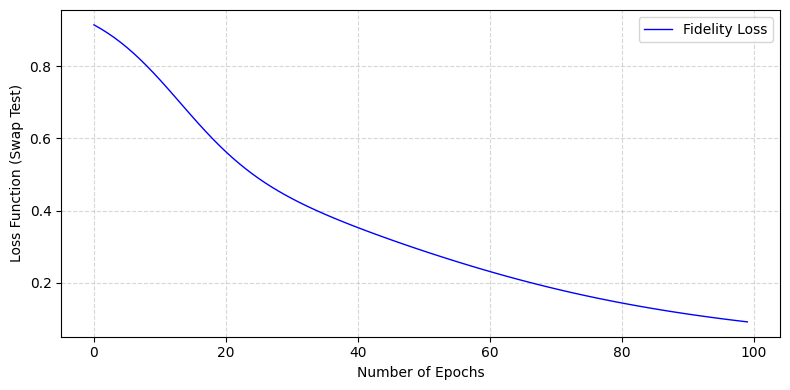

In [12]:
plt.figure(figsize=(8, 4))
plt.plot(range(NUM_EPOCHS), losses, color='blue', linewidth=1, label="Fidelity Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss Function (Swap Test)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# **Contextual Probability Distribution**

In [13]:
def measure_state_distribution(qc, T, shots=10000):
    sim = AerSimulator()
    qc = qc.copy()
    qc.measure_all()
    tqc = transpile(qc, sim)
    result = sim.run(tqc, shots=shots).result()
    counts = result.get_counts()
    
    # Convert counts to probability distribution
    dist = np.zeros(2**T)
    for bitstring, count in counts.items():
        index = int(bitstring, 2)
        dist[index] = count / shots
    return dist

In [14]:
def plot_contextual_distribution_comparison(original_dist, generated_dist, title="Contextual Probability Distribution"):
    num_states = len(original_dist)
    labels = [format(i, f'0{int(np.log2(num_states))}b') for i in range(num_states)]
    x = np.arange(len(labels))

    plt.figure(figsize=(10, 5))
    bar_width = 0.35

    plt.bar(x, generated_dist, width=bar_width, color='coral', alpha=0.5, label="Generated Prior Distribution")
    plt.plot(x, original_dist, color='orangered', marker='o', linewidth=2, label="Original Prior Distribution")

    plt.xticks(ticks=x, labels=labels)
    plt.xlabel("Qubit States")
    plt.ylabel("Normalized Counts after Measurement")
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


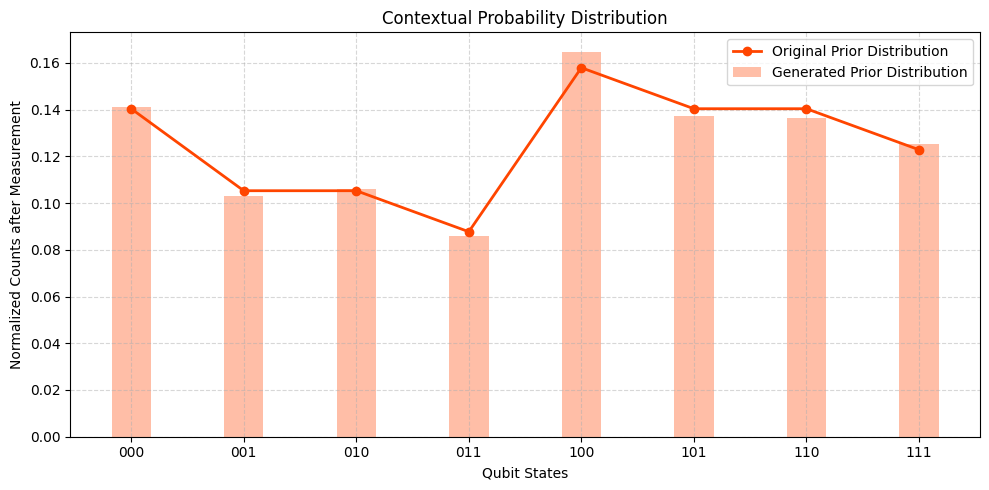

In [15]:
original_dist = get_context_prob_distribution(X_train, T)

context_loader_circuit = build_context_loader_circuit(original_dist, T)
generated_dist = measure_state_distribution(context_loader_circuit, T)

plot_contextual_distribution_comparison(original_dist, generated_dist)

# **KL Divergence Calculation**

In [16]:
kl_div = np.sum(rel_entr(original_dist, generated_dist))
print("KL Divergence:", kl_div)

KL Divergence: 0.000314578861795979
